In [368]:
from model_builder import ModelBuilder
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
import os
from model_utils import *
import scipy.stats as stats 

## Model Deep Dive: DAT

Using the DAT Dataset, build a model that progressively accounts for different aspects of the data...

Team Composition:
- vis_img
- int_verb
- ort_img
- rep_man
- soc_pers
- team_size

Task Features:
- None

Conversation Features (All)

In [369]:
# PARAMETERS
min_num_chats = 0
desired_target = "duration"
data_path = "../output/"
output_path = "./results/dat/" + "min=" + str(min_num_chats) + "/" + desired_target + "/"
validation_results_output_name = output_path + "dat_lasso_ridge_experiments" + "_" + desired_target + "_min_chat_num_" + str(min_num_chats) + ".csv"

In [370]:
def read_and_preprocess_data(path, min_num_chats):
    conv_data  = pd.read_csv(path)

    # Filter this down to teams that have at least min_num of chats
    # Can also comment this out to re-run results on *all* conversations!
    conv_data = conv_data[conv_data["sum_num_messages"] >= min_num_chats]

    # Save the important information

    # Composition features
    '''
        - vis_img
        - int_verb
        - ort_img
        - rep_man
        - soc_pers
        - team_size
    '''
    team_composition_features =  pd.get_dummies(conv_data[["vis_img", "int_verb", "ort_img", "rep_man", "soc_pers", "team_size"]])

    # possible targets to try
    targets = conv_data[["efficiency","score","duration"]]

    # Read in the config file and use that the drop the extraneous columns
    with open('./config.json', "rb") as json_file:
        config = json.load(json_file)

    conv_features = conv_data.drop(config["dat"]['cols_to_ignore'], axis = 1)

    # Normalization
    # team_composition_features = pd.DataFrame(StandardScaler().fit_transform(team_composition_features), columns = team_composition_features.columns)
    conv_features = pd.DataFrame(StandardScaler().fit_transform(conv_features), columns = conv_features.columns)
    # drop na cols
    conv_features = conv_features.dropna(axis = 1)

    targets = pd.DataFrame(StandardScaler().fit_transform(targets), columns = targets.columns)

    return team_composition_features, conv_features, targets

In [371]:
team_composition_features, conv_features, targets = read_and_preprocess_data(data_path + 'conv/DAT_output_conversation_level.csv', min_num_chats=min_num_chats)

In [372]:
len(conv_features)

195

## Train-Test Split

In [320]:
X = pd.concat([team_composition_features.reset_index(drop=True), conv_features.reset_index(drop=True)], axis=1)

In [321]:
X_train, X_test, y_train, y_test = train_test_split(X, targets, random_state=42, test_size=0.2)

## Try LASSO/Ridge Regression, one Set of Features at a Time

Here, we want to implement *leave-one-out cross-validation*, and use Q^2 as our metric.



In [322]:
# Note --- this uses k-fold cross-validation with k = 5 (the default)
# We are testing 10,000 different alphas, so I feel like this is an OK heuristic
def get_optimal_alpha(y_target, feature_columns_list, lasso):

    if(lasso == True):
        model = LassoCV(n_alphas = 10000)
        model.fit(X_train[feature_columns_list], y_train[y_target])
    else:
        model = RidgeCV(n_alphas = 10000)
        model.fit(X_train[feature_columns_list], y_train[y_target])
        
    return model.alpha_ # optimal alpha

In [323]:
def fit_regularized_linear_model(y_target, feature_columns_list, lasso=True, tune_alpha=False):

    if not tune_alpha:
        alpha = 1.0
    else:
        # Hyperparameter tune the alpha
        alpha = get_optimal_alpha(y_target, feature_columns_list, lasso=True)

    if lasso:
        model = Lasso(alpha=alpha)
    else:
        model = Ridge(alpha=alpha)

    # Calculation of Q^2 metric
    squared_model_prediction_errors = []
    squared_average_prediction_errors = []

    # Initialize a list to store coefficients
    coefficients_list = []

    # Leave one out -- iterate through the entire length of the dataset
    for i in range(len(y_train)):
        # Store the evaluation datapoint
        evaluation_X = X_train.iloc[[i]]
        evaluation_y = y_train.iloc[[i]][y_target]

        # Drop the ith datapoint (leave this one out)
        X_train_fold = X_train.drop(X_train.index[i])
        y_train_fold = y_train.drop(y_train.index[i])[y_target]

        # Fit the model
        model.fit(X_train_fold[feature_columns_list], y_train_fold)

        # Save the Prediction Error
        prediction = model.predict(evaluation_X[feature_columns_list])[0]
        squared_model_prediction_errors.append((evaluation_y - prediction) ** 2)

        # Save the Total Error for this fold
        squared_average_prediction_errors.append((evaluation_y - np.mean(y_train_fold)) ** 2)

        # Append the coefficients to the list
        coefficients_list.append(model.coef_)

    # Create a DataFrame with feature names as rows and iteration results as columns
    feature_coefficients = pd.DataFrame(coefficients_list, columns=feature_columns_list).T

    q_squared = 1 - (np.sum(squared_model_prediction_errors) / np.sum(squared_average_prediction_errors))
    print("Q^2: " + str(q_squared))

    return model, q_squared, feature_coefficients


In [324]:
def display_feature_coefficients(feature_coef_df):
    # Initialize a list to store DataFrames for each feature
    dfs = []

    # Iterate through the rows of the input DataFrame
    for feature_name, coefficients in feature_coef_df.iterrows():
        # Calculate the confidence interval without NaN values
        non_nan_coefficients = coefficients[~np.isnan(coefficients)]
        if len(non_nan_coefficients) == 0:
            # Handle the case where there are no valid coefficients
            continue

        mean_coef = non_nan_coefficients.mean()

        # Check if all coefficients in the row are the same
        if len(coefficients.unique()) == 1:
            # If all coefficients are the same, set the lower and upper CI to the mean
            confidence_interval = (mean_coef, mean_coef)
        else:
            std_error = non_nan_coefficients.sem()
            confidence_interval = stats.t.interval(0.95, len(non_nan_coefficients) - 1, loc=mean_coef, scale=std_error)

        # Create a DataFrame for the summary data
        temp_df = pd.DataFrame({
            "Feature": [feature_name],
            "Mean": [mean_coef],
            "Lower_CI": [confidence_interval[0]],
            "Upper_CI": [confidence_interval[1]]
        })

        # Append the temporary DataFrame to the list
        dfs.append(temp_df)

    # Concatenate all the DataFrames in the list into the final summary DataFrame
    summary_df = pd.concat(dfs, ignore_index=True)

    return summary_df

In [325]:
def sort_by_mean_abs(df):
    return df.reindex(df["Mean"].abs().sort_values(ascending=False).index)

In [326]:
# Go through the different types of features and fit models

# First, create a data structure that saves the result
result = {
    "model": [],
    "model_type": [],
    "features_included": [],
    "alpha": [],
    "q_squared": []
}

result_df = pd.DataFrame(result)

## Team composition features

In [327]:
model_ridge_composition, mrc_q2, mrc_feature_coefficients = fit_regularized_linear_model(desired_target, team_composition_features.columns, lasso = False, tune_alpha = True)

result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_composition], "model_type": ["Ridge"], "features_included": ["Team Composition"], "alpha": [model_ridge_composition.alpha.round(4)], "q_squared": [mrc_q2]})], ignore_index=True)

Q^2: -0.23081357225117127


In [328]:
directory = os.path.dirname(output_path + 'mrc_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mrc_feature_coefficients.to_csv(output_path + 'mrc_feature_coefficients' + '.csv')

In [329]:
sort_by_mean_abs(display_feature_coefficients(mrc_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
15,soc_pers_Mixed,0.636951,0.617873,0.656029
7,ort_img_High,0.502533,0.493958,0.511109
14,soc_pers_Low,-0.380222,-0.390853,-0.369590
1,vis_img_High,-0.303540,-0.309151,-0.297930
4,int_verb_High,-0.269960,-0.275626,-0.264294
9,ort_img_Mixed,-0.262709,-0.274168,-0.251249
13,soc_pers_High,-0.256729,-0.267353,-0.246106
11,rep_man_Low,-0.251557,-0.258539,-0.244574
3,vis_img_Mixed,0.246860,0.239919,0.253800
8,ort_img_Low,-0.239825,-0.247033,-0.232617


In [330]:
model_lasso_composition, mlc_q2, mlc_feature_coefficients = fit_regularized_linear_model(desired_target, team_composition_features.columns, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_composition], "model_type": ["Lasso"], "features_included": ["Team Composition"], "alpha": [model_lasso_composition.alpha.round(4)], "q_squared": [mlc_q2]})], ignore_index=True)

Q^2: -0.021484772022150267


In [331]:
directory = os.path.dirname(output_path + 'mlc_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mlc_feature_coefficients.to_csv(output_path + 'mlc_feature_coefficients' + '.csv')

In [332]:
sort_by_mean_abs(display_feature_coefficients(mlc_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
4,int_verb_High,-0.011886,-0.015612,-0.008159
0,team_size,0.001004,0.000357,0.001652
1,vis_img_High,-0.000791,-0.001764,0.000182
2,vis_img_Low,0.000000,0.000000,0.000000
3,vis_img_Mixed,0.000000,0.000000,0.000000
5,int_verb_Low,0.000000,0.000000,0.000000
6,int_verb_Mixed,0.000000,0.000000,0.000000
7,ort_img_High,0.000000,0.000000,0.000000
8,ort_img_Low,0.000000,0.000000,0.000000
9,ort_img_Mixed,0.000000,0.000000,0.000000


## Conversation Alone

In [333]:
model_lasso_comms, mlcom_q2, mlcom_feature_coefficients = fit_regularized_linear_model(desired_target, conv_features.columns, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_comms], "model_type": ["Lasso"], "features_included": ["Communication"], "alpha": [model_lasso_comms.alpha.round(4)], "q_squared": [mlcom_q2]})], ignore_index=True)

Q^2: 0.14831939762683066


In [334]:
directory = os.path.dirname(output_path + 'mlcom_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mlcom_feature_coefficients.to_csv(output_path + 'mlcom_feature_coefficients' + '.csv')

In [335]:
sort_by_mean_abs(display_feature_coefficients(mlcom_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
657,max_user_sum_time_diff,0.109810,0.106760,0.112860
70,max_negation,0.102531,0.098387,0.106675
498,average_user_sum_relative,0.091538,0.086705,0.096371
270,max_hedge_naive,0.073923,0.070289,0.077558
1102,average_user_avg_subjunctive,-0.065978,-0.068383,-0.063574
...,...,...,...,...
383,stdev_user_sum_num_messages,0.000000,0.000000,0.000000
384,min_user_sum_num_messages,0.000000,0.000000,0.000000
386,average_user_sum_info_exchange_zscore_chats,0.000000,0.000000,0.000000
387,stdev_user_sum_info_exchange_zscore_chats,0.000000,0.000000,0.000000


In [336]:
model_ridge_comms, mrcom_q2, mrcom_feature_coefficients = fit_regularized_linear_model(desired_target, conv_features.columns, lasso = False, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_comms], "model_type": ["Ridge"], "features_included": ["Communication"], "alpha": [model_ridge_comms.alpha.round(4)], "q_squared": [mrcom_q2]})], ignore_index=True)

Q^2: -0.3059283616876818


In [337]:
directory = os.path.dirname(output_path + 'mrcom_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mrcom_feature_coefficients.to_csv(output_path + 'mrcom_feature_coefficients' + '.csv')

In [338]:
sort_by_mean_abs(display_feature_coefficients(mrcom_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
657,max_user_sum_time_diff,0.056684,0.055968,0.057401
19,average_info_exchange_zscore_conversation,0.055174,0.053976,0.056372
1110,discursive_diversity,0.051548,0.050524,0.052572
655,stdev_user_sum_time_diff,0.050506,0.049845,0.051167
36,stdev_conjunction,0.047869,0.047174,0.048565
...,...,...,...,...
241,min_hedge_words,0.000000,0.000000,0.000000
872,min_user_avg_sexual,0.000000,0.000000,0.000000
233,min_first_person,0.000000,0.000000,0.000000
229,min_positive_words,0.000000,0.000000,0.000000


## Model with All Features

In [339]:
all_features = list(team_composition_features.columns) + list(conv_features.columns)
model_lasso_all, mlall_q2, mlall_feature_coefficients = fit_regularized_linear_model(desired_target, all_features, lasso = True, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_lasso_all], "model_type": ["Lasso"], "features_included": ["All Features"], "alpha": [model_lasso_all.alpha.round(4)], "q_squared": [mlall_q2]})], ignore_index=True)


Q^2: 0.09012372009140912


In [340]:
directory = os.path.dirname(output_path + 'mlall_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mlall_feature_coefficients.to_csv(output_path + 'mlall_feature_coefficients' + '.csv')

In [341]:
sort_by_mean_abs(display_feature_coefficients(mlall_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
673,max_user_sum_time_diff,0.164751,0.155119,0.174383
52,stdev_conjunction,0.119404,0.112972,0.125837
1093,max_user_avg_2nd_person,-0.109647,-0.113992,-0.105302
86,max_negation,0.101435,0.096403,0.106468
1118,average_user_avg_subjunctive,-0.095809,-0.100265,-0.091353
...,...,...,...,...
398,average_user_sum_num_messages,0.000000,0.000000,0.000000
399,stdev_user_sum_num_messages,0.000000,0.000000,0.000000
400,min_user_sum_num_messages,0.000000,0.000000,0.000000
401,max_user_sum_num_messages,0.000000,0.000000,0.000000


In [342]:
model_ridge_all, mrall_q2, mrall_feature_coefficients = fit_regularized_linear_model(desired_target, all_features, lasso = False, tune_alpha = True)
result_df = pd.concat([result_df, pd.DataFrame({"model": [model_ridge_all], "model_type": ["Ridge"], "features_included": ["All Features"], "alpha": [model_ridge_all.alpha.round(4)], "q_squared": [mrall_q2]})], ignore_index=True)

Q^2: -0.30907358674611585


In [343]:
directory = os.path.dirname(output_path + 'mrall_feature_coefficients' + '.csv')
if not os.path.exists(directory):
    os.makedirs(directory)
mrall_feature_coefficients.to_csv(output_path + 'mrall_feature_coefficients' + '.csv')

In [344]:
sort_by_mean_abs(display_feature_coefficients(mrall_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
35,average_info_exchange_zscore_conversation,0.055831,0.054641,0.057022
673,max_user_sum_time_diff,0.055792,0.055078,0.056506
671,stdev_user_sum_time_diff,0.050288,0.049621,0.050956
52,stdev_conjunction,0.048708,0.048011,0.049405
1126,discursive_diversity,0.048170,0.047193,0.049147
...,...,...,...,...
161,min_social,0.000000,0.000000,0.000000
165,min_indefinite_pronoun,0.000000,0.000000,0.000000
736,min_user_sum_direct_question,0.000000,0.000000,0.000000
169,min_religion,0.000000,0.000000,0.000000


# Dataframe that summarizes all these experiments!

In [345]:
result_df.sort_values(by = "q_squared", ascending = False)

,model,model_type,features_included,alpha,q_squared
2,Lasso(alpha=0.1793679353199349),Lasso,Communication,0.1794,0.148319
4,Lasso(alpha=0.10428485862212458),Lasso,All Features,0.1043,0.090124
1,Lasso(alpha=0.056837995814259724),Lasso,Team Composition,0.0568,-0.021485
0,Ridge(alpha=0.056837995814259724),Ridge,Team Composition,0.0568,-0.230814
3,Ridge(alpha=0.1793679353199349),Ridge,Communication,0.1794,-0.305928
5,Ridge(alpha=0.10428485862212458),Ridge,All Features,0.1043,-0.309074


In [346]:
# Save for comparing results
directory = os.path.dirname(validation_results_output_name)
if not os.path.exists(directory):
    os.makedirs(directory)
result_df.sort_values(by = "q_squared", ascending = False).to_csv(validation_results_output_name)

# Feature Importance

In [347]:
sort_by_mean_abs(display_feature_coefficients(mlall_feature_coefficients))

,Feature,Mean,Lower_CI,Upper_CI
673,max_user_sum_time_diff,0.164751,0.155119,0.174383
52,stdev_conjunction,0.119404,0.112972,0.125837
1093,max_user_avg_2nd_person,-0.109647,-0.113992,-0.105302
86,max_negation,0.101435,0.096403,0.106468
1118,average_user_avg_subjunctive,-0.095809,-0.100265,-0.091353
...,...,...,...,...
398,average_user_sum_num_messages,0.000000,0.000000,0.000000
399,stdev_user_sum_num_messages,0.000000,0.000000,0.000000
400,min_user_sum_num_messages,0.000000,0.000000,0.000000
401,max_user_sum_num_messages,0.000000,0.000000,0.000000


In [348]:
def plot_top_n_features(data, n, filepath):
    # Calculate the absolute mean value and sort the DataFrame in descending order
    data['Absolute_Mean'] = data['Mean'].abs()
    top_n_features = data.sort_values(by='Absolute_Mean', ascending=False).head(n)

    # Define color mapping for the features
    color_map = {}
    name_map = {}
    for feature in conv_features.columns:
        color_map[feature] = 'powderblue'
        name_map[feature] = "Conversation Feature"
    for feature in team_composition_features.columns:
        color_map[feature] = 'lightpink'
        name_map[feature] = "Team Composition Feature"

    # Create a horizontal bar graph
    plt.figure(figsize=(10, 6))

    handles = []

    for feature in top_n_features['Feature']:
        color = color_map.get(feature, 'k')  # Default to black if not in any list
        bars = plt.barh(feature, top_n_features[top_n_features['Feature'] == feature]['Mean'], color=color)
        handles.append(bars[0])

    # Customize the plot
    plt.xlabel('Mean Coefficient (Across LOO Cross Validation)', fontsize = 14)
    plt.title(f'Top {n} features for {desired_target}: Divergent Association Problem (min chats = {min_num_chats})', fontsize=20)
    plt.gca().invert_yaxis()  # Invert the y-axis to display the highest value at the top

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Create a legend outside the plot area with unique labels
    unique_features = []
    unique_labels = []
    for feature in top_n_features['Feature']:
        if name_map.get(feature, feature) not in unique_labels:
            unique_labels.append(name_map.get(feature, feature))
            unique_features.append(feature)

    legend_handles = [plt.Line2D([0], [0], color=color_map.get(feature, 'k'), lw=4, label=name_map.get(feature, feature)) for feature in unique_features]
    plt.legend(handles=legend_handles, loc='center left', fontsize = 14, bbox_to_anchor=(1, 0.5))

    # Add labels to the bars with increased text size and Mean rounded to 2 decimals, consistently inside the bar
    label_offset = 0.4  # Adjust this value for proper spacing
    for bar, value, feature in zip(handles, top_n_features['Mean'], top_n_features['Feature']):
        label_x = (max(value, 0) if value >= 0 else min(value, 0))
        bbox = bar.get_bbox()
        label_y = bbox.bounds[1] + label_offset
        if value >= 0:
            plt.text(label_x, label_y, f'{value:.2f}', va='center', fontsize=12)
        else:
            plt.text(label_x, label_y, f'{value:.2f}', ha='right', va='center', fontsize=12)

    # Show the plot
    plt.savefig(filepath + ".svg")
    plt.savefig(filepath + ".png")
    plt.show()

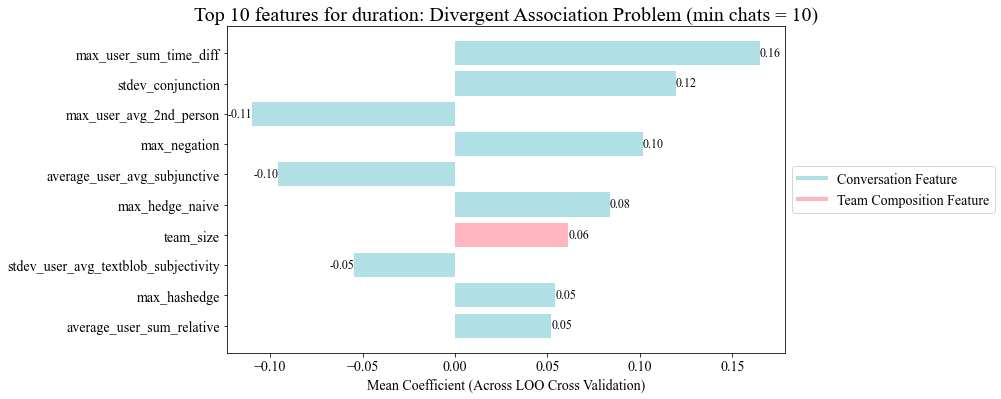

In [349]:
plot_top_n_features(display_feature_coefficients(mlall_feature_coefficients), 10, filepath = "./figures/dat" + "_" + desired_target + "_min_chat_num_" + str(min_num_chats))

Questions:
- More deeply understand difference between LASSO and Ridge
- Better understand `alpha` hyperparameter
- Why doesn't more features mean a better R^2? (Wouldn't the model 'throw out' features that don't work?)